# PPO, R-PPO and VAE comparison

## Frauds in the dataset
We compute how much money a fraudster is able to collect with a card in the simulator.

In [1]:
from parameters import CardSimParameters

p = CardSimParameters.paper_params()
fraudulent_cards, terminals, transactions = p.get_simulation_data()


KeyboardInterrupt



In [ ]:
from parameters import CardSimParameters, Parameters

params = Parameters(cardsim=CardSimParameters.paper_params())
env = params.create_env()
banksys = env.system

In [ ]:
frauds = [t for t in transactions if t.is_fraud]
frauds.sort(key=lambda t: t.timestamp)
print(len(frauds))
n_cards = set(t.card_id for t in frauds)
print(len(n_cards))

In [ ]:
import matplotlib.pyplot as plt

amounts = [t.amount for t in transactions]
plt.boxplot(amounts, vert=False)

In [ ]:
plt.boxplot(amounts, vert=True, showfliers=False)


In [6]:
from tqdm import tqdm

blocked_cards = set()
frauds_amounts = list[float]()

for trx in tqdm(frauds):
    if trx.card_id in blocked_cards:
        continue
    if banksys.process_transaction(trx):
        blocked_cards.add(trx.card_id)
        frauds_amounts.append(0.0)
    else:
        undetected_frauds.append(trx)

100%|██████████| 158171/158171 [03:48<00:00, 693.17it/s]  


In [7]:
len(undetected_frauds)

3205

## Score over training time

In [12]:
import numpy as np

logdirs = {
    "PPO": "logs/PPO",
    "VAE": "logs/VAE",
    "R-PPO": "logs/RPPO",
}


def moving_average(data, window_size=1):
    """Compute the moving average of a 1D array."""
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


logs/PPO
There are 1 runs in PPO
logs/VAE
There are 1 runs in VAE
logs/RPPO
There are 1 runs in R-PPO


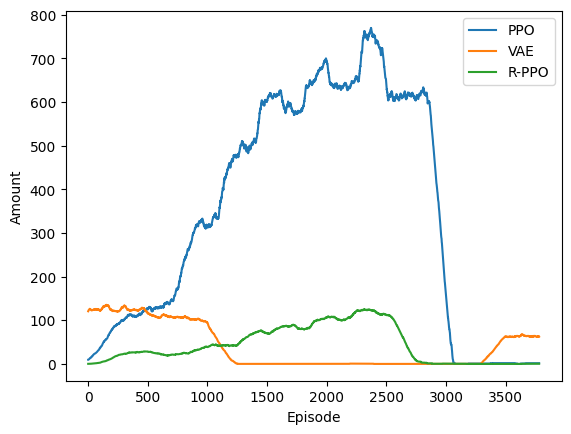

In [13]:
import matplotlib.pyplot as plt
from plots import Experiment


for label, logdir in logdirs.items():
    print(logdir)
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    amounts = exp.amounts_over_time
    mean, std = exp.mean_std_amounts_over_time
    mean = moving_average(mean, 200)[:-20]
    std = moving_average(std, 200)[:-20]
    # Compute the 95% confidence interval from the STD
    ci95 = 1.96 * (std / exp.n_runs**0.5)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Amount")
plt.legend()
plt.savefig("amount-over-time.svg")


In [14]:
exp = Experiment.load("logs/vae-test/")
run = next(iter(exp.runs.values()))
print(run.items[0])

FileNotFoundError: [Errno 2] No such file or directory: 'logs/vae-test/params.json'

## Number of transactions per card over time

There are 1 runs in PPO
There are 1 runs in VAE


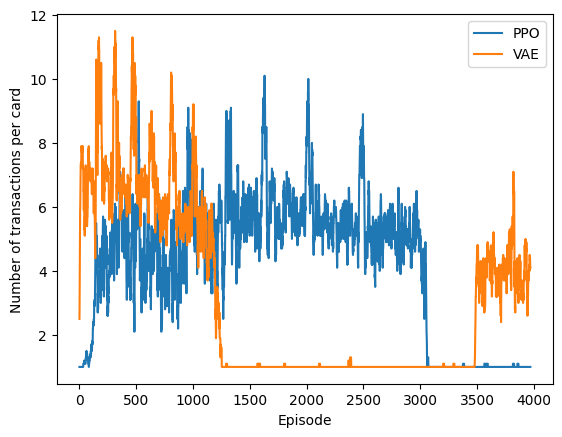

In [8]:
import matplotlib.pyplot as plt
from plots import Experiment


for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    data = exp.n_transactions_over_time
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    mean = moving_average(mean, window_size=10)[:-20]
    std = moving_average(std, window_size=10)[:-20]
    # Compute the 95% confidence interval from the STD
    ci95 = 1.96 * (std / exp.n_runs**0.5)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Number of transactions per card")
plt.legend()
plt.savefig("n-transactions.svg")

## Total amount collected

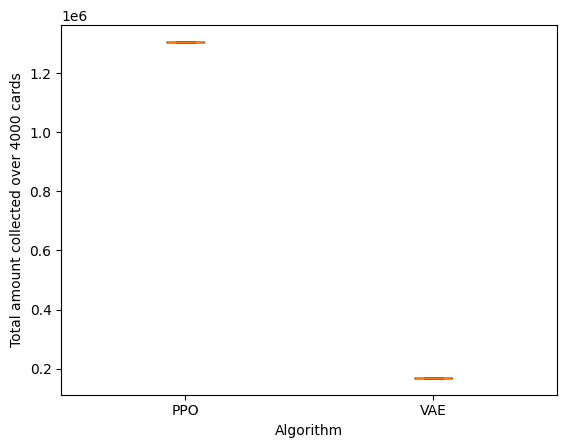

In [9]:
import matplotlib.pyplot as plt
from plots import Experiment

amounts = []
labels = []
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    amounts.append(exp.total_amounts)
    labels.append(label)

plt.boxplot(amounts, tick_labels=labels)
plt.ylabel("Total amount collected over 4000 cards")
plt.xlabel("Algorithm")
plt.savefig("boxplot-amounts.svg")
plt.show()